In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#These are some matplot lib configurations that I like to use. 
mpl.rc("text", usetex=True) #if tou have Latex set this to true and matplotlib will render labels in latex
mpl.rc("font", family = "serif") #Serif font in matplotlib
mpl.rc("figure",figsize=(9,6)) #Increase default figure size
%config InlineBackend.figure_format = 'retina' #If you have a high res display, render the plots more nicely
# If you look at this in a dark mode notebook uncomment these lines
# mpl.style.use('dark_background') #Use a dark background for matplotlib figures if youre using dark theme
# plt.rcParams.update({"figure.facecolor": "111111","savefig.facecolor": "212121"})

In [2]:
import geopandas as gpd
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
covid = pd.read_csv('data/Hospitalization_all_locs.csv')

In [4]:
states = gpd.read_file('data/cb_2018_us_state_500k.shp')
states = states.to_crs('USA_Contiguous_Albers_Equal_Area_Conic')
states = states.astype({'STATEFP': 'int64', 'GEOID':'int64'})
states = states.loc[states['STATEFP'] < 60] #Not states
states = states.loc[states['STATEFP'] != 2] #bye alaska
states = states.loc[states['STATEFP'] != 15] #bye hawaii
# #states = states.assign(sind=lambda df: df.index.astype(str))

In [5]:
state_pop = pd.read_excel('data/nst-est2019-01.xlsx', header=1).dropna(0)
state_pop["Region"] = state_pop['Region'].str.strip('.')
state_pop = state_pop.rename(columns={'Region':'NAME', 2019:'pop2019'})
state_pop = state_pop[['NAME', 'pop2019']]

In [6]:
minimal = states[['GEOID', 'NAME', 'STUSPS', 'geometry']]
minimal = minimal.merge(state_pop, on='NAME')

In [7]:
l = []
for i,s in enumerate(states['NAME']):
    sdata = covid.loc[covid['location_name']==s]
    dtdates = pd.to_datetime(sdata['date'])
    sdata = sdata.loc[dtdates>pd.to_datetime('2020-02')]
    dtdates = pd.to_datetime(sdata['date'])
    dates = list(sdata['date'].values)
    td_mean = list(sdata['totdea_mean'].values)
    td_lower = list(sdata['totdea_lower'].values)
    td_upper = list(sdata['totdea_upper'].values)
    td_todate = td_mean[np.argmin(np.abs(dtdates-pd.to_datetime('2020-04-12')))]
    td_proj = td_mean[-1]
    l.append((s,  td_todate, td_proj, dtdates.values, td_mean, td_lower, td_upper))

In [8]:
state_covid = pd.DataFrame(data = l,columns=['NAME', 'td_todate', 'td_proj','dates','td_mean', 'td_lower', 'td_upper'])

In [9]:
minimal = minimal.merge(state_covid,on='NAME')

In [10]:
minimal = minimal.assign(td_per10k_now=lambda df: 1e4*df['td_todate']/df['pop2019'] )
minimal = minimal.assign(td_per10k_proj=lambda df: 1e4*df['td_proj']/df['pop2019'] )
minimal = minimal.assign(
    td_tocome=lambda df: (df['td_per10k_proj'] - df['td_per10k_now'])/df['td_per10k_proj'] )

In [11]:
#minimal.crs = 'USA_Contiguous_Albers_Equal_Area_Conic'

# Some maps showing the deadliness of COVID19 in the Continental US



### Here states are colored by their current per capita death rates.

You can mouseover the states to see their current rates (updated 4/12/20) and the projections from the IHME for August 1, 2020. Rates are given in deaths per $10^4$ people. Unforuntely I havent been able to display a colorbar yet but blue corresponds to higher values and yellow to lower ones. Wyoming currently has 0 so and New York has the most for reference.

~~If you click on a state, its IHME data will appear on the plot below. The solid line is the model average and the dashed lines indiciate the upper and lower bounds from the model.~~

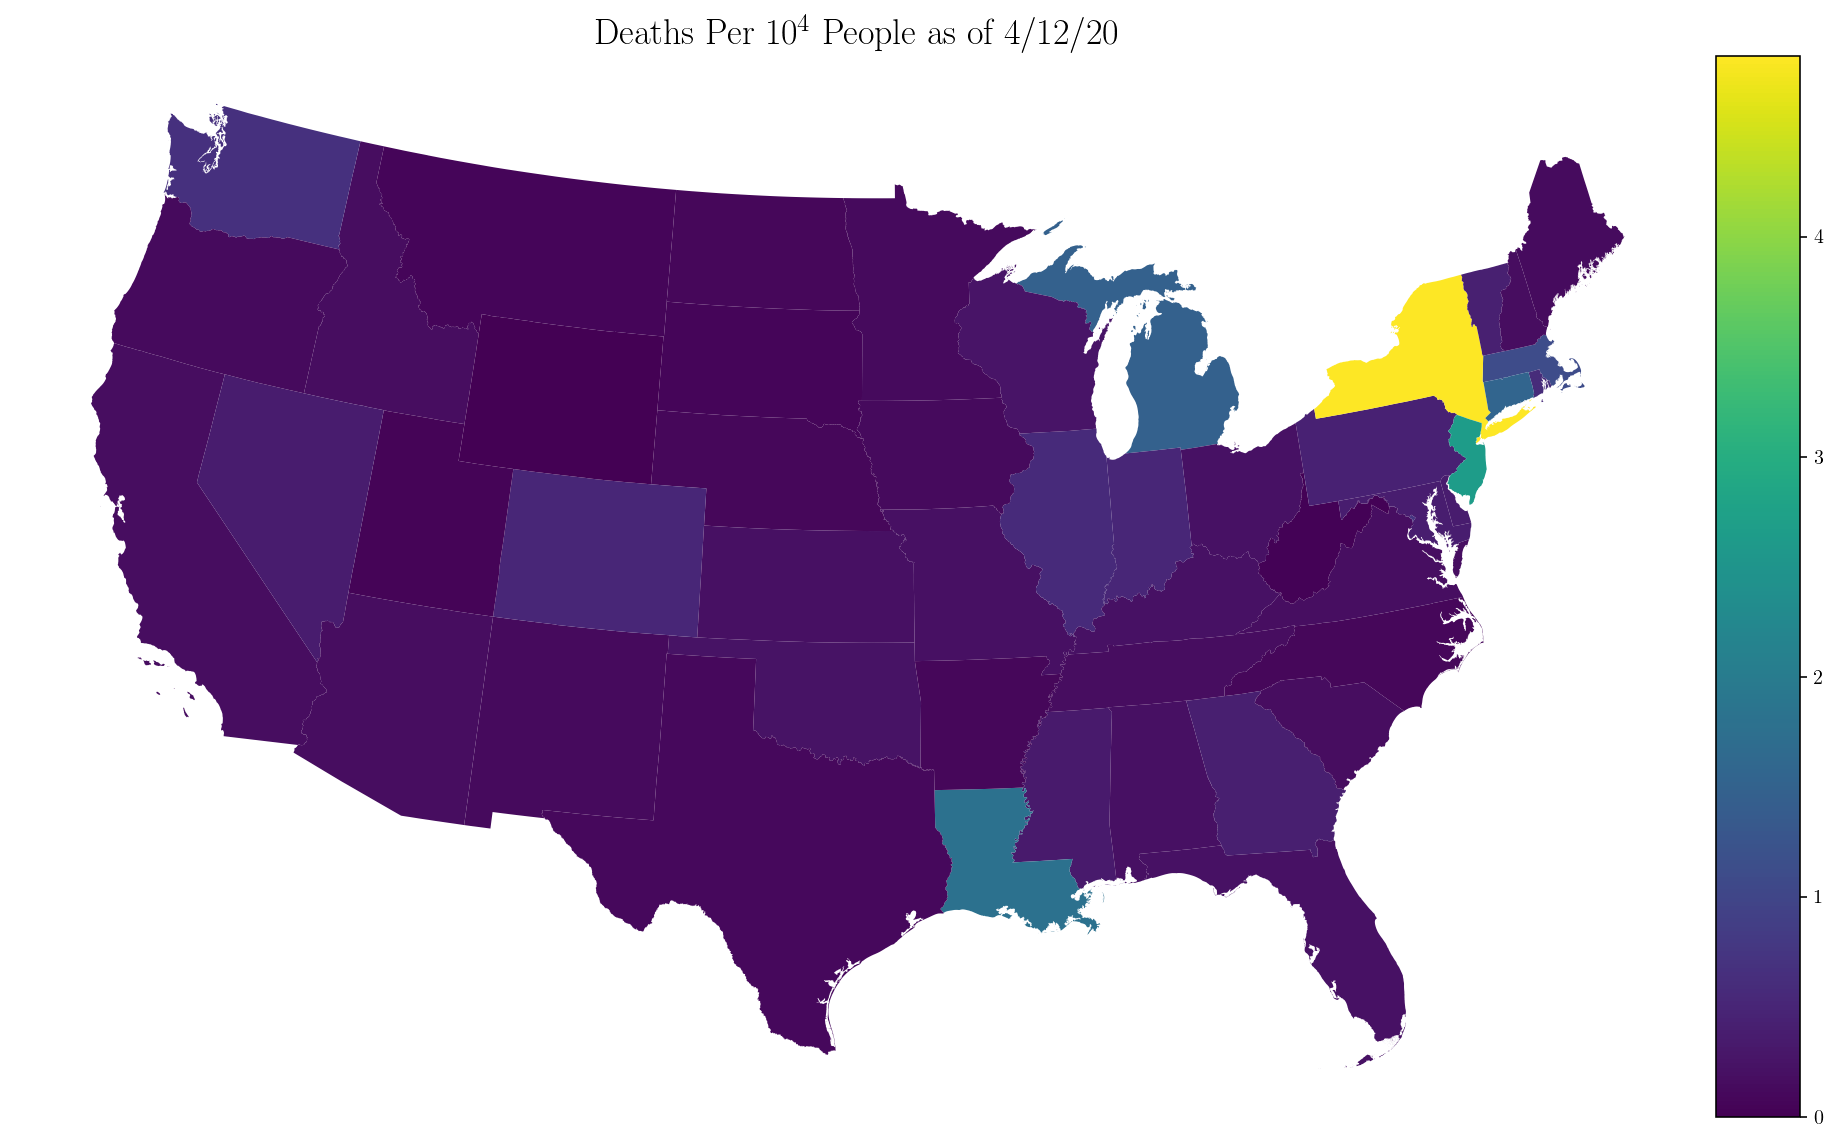

In [12]:
fig = plt.figure(figsize=(16,10))
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
minimal.plot(ax=ax, column='td_per10k_now', legend=True, cax=cax)
ax.set_title('Deaths Per $10^4$ People as of 4/12/20',fontsize=18)
ax.axis('off')
plt.show()

### Here state are colored by the fraction of projected per captita deaths that have yet to occur.

~~It a little clunky but if you click here it will also update the graph above (hopefully I'll make this better soon).~~

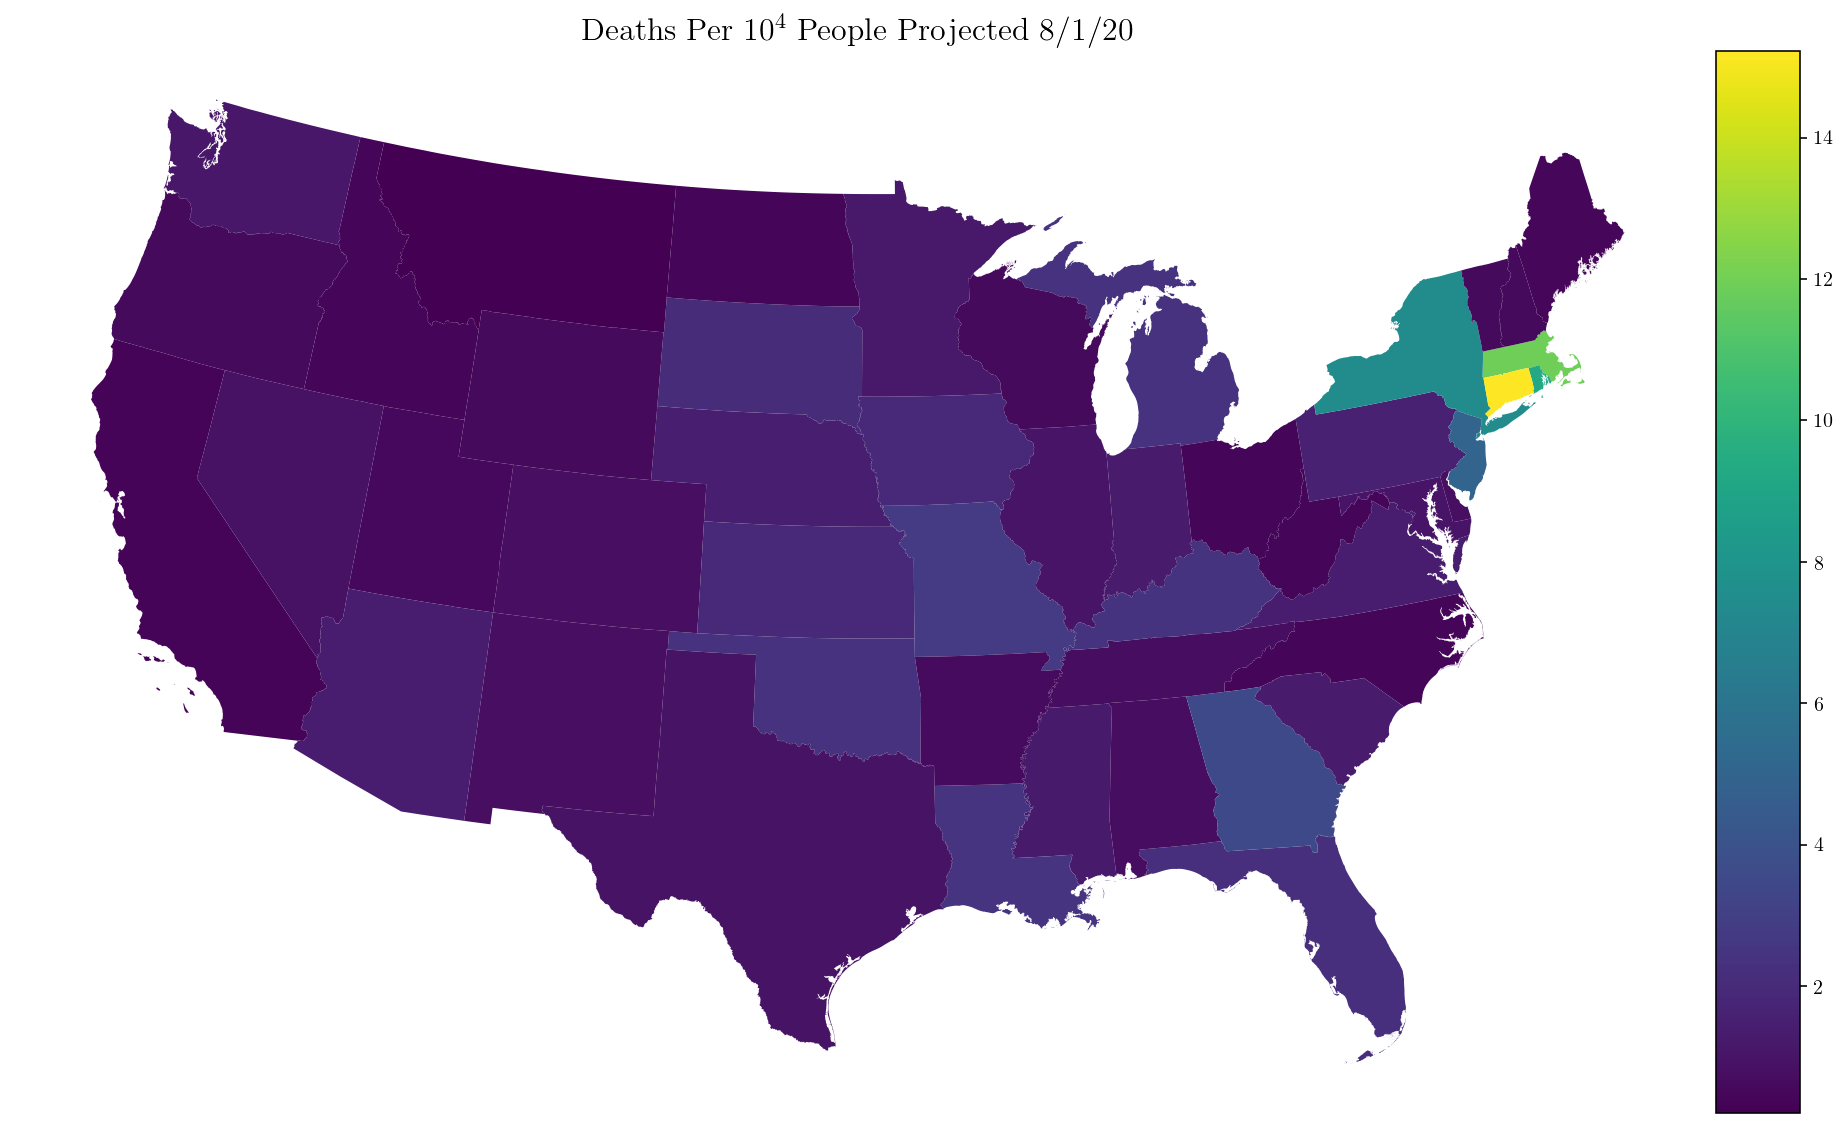

In [13]:
fig = plt.figure(figsize=(16,10))
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
minimal.plot(ax=ax, column='td_per10k_proj', legend=True, cax=cax)
ax.set_title('Deaths Per $10^4$ People Projected 8/1/20',fontsize=16)
ax.axis('off')
plt.show()

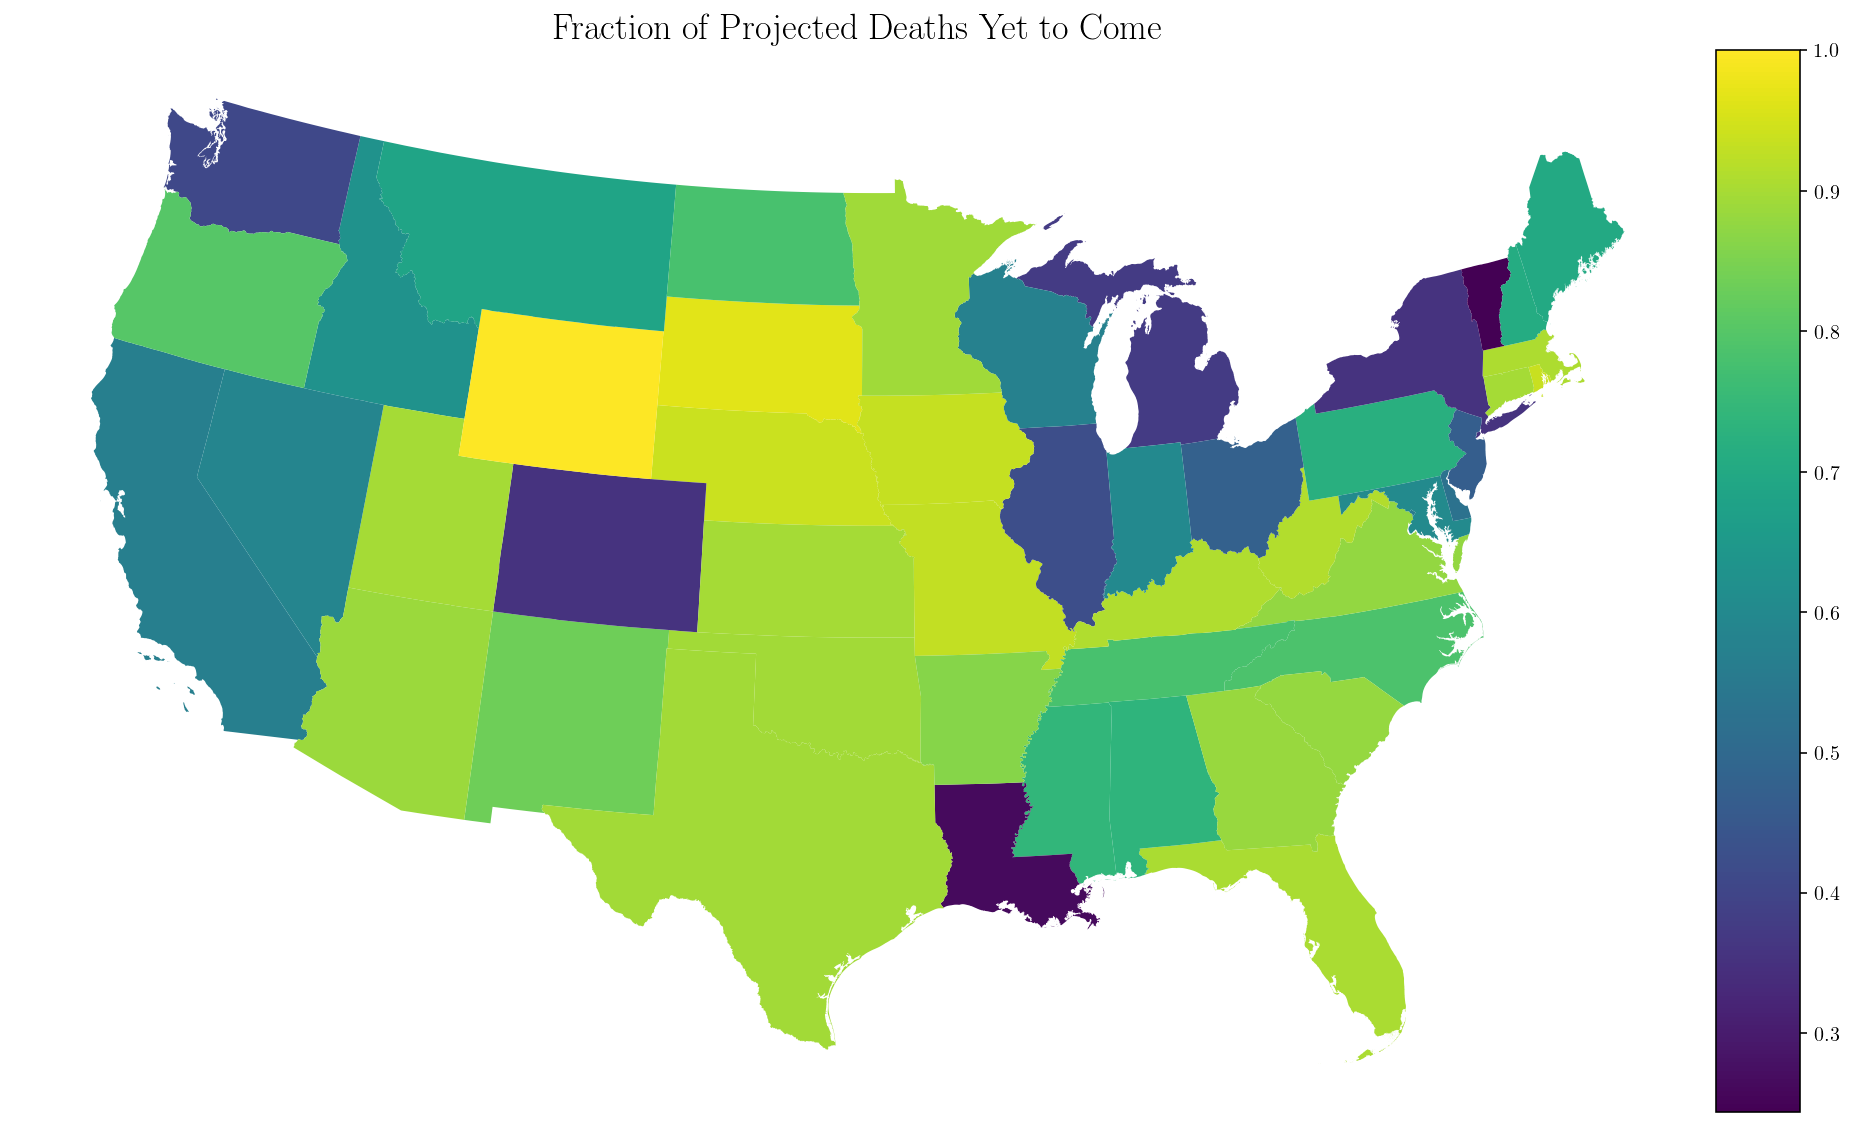

In [14]:
fig = plt.figure(figsize=(16,10))
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
minimal.plot(ax=ax, column='td_tocome', legend=True, cax=cax)
ax.set_title('Fraction of Projected Deaths Yet to Come',fontsize=18)
ax.axis('off')
plt.show()

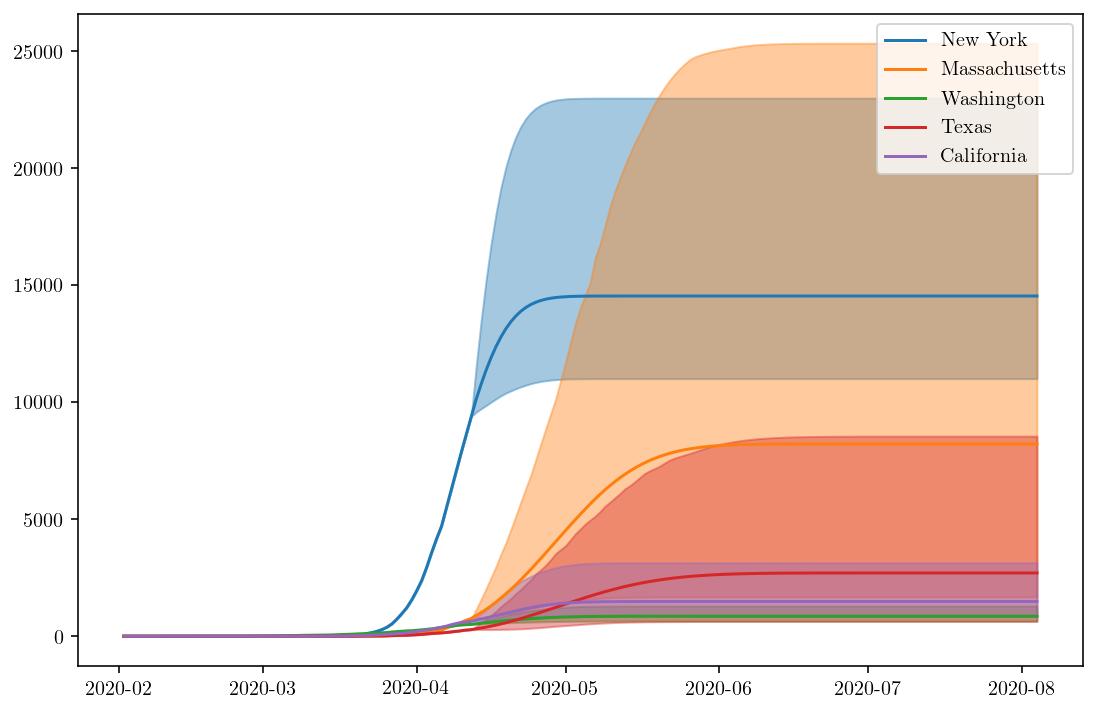

In [15]:
plt.figure()
for i,s in enumerate(['New York', 'Massachusetts', 'Washington', 'Texas', 'California']):
    sdata = minimal.loc[minimal['NAME']==s]
    plt.plot(sdata['dates'].values[0], sdata['td_mean'].values[0], label = s)
    plt.fill_between(sdata['dates'].values[0], sdata['td_lower'].values[0],
                     sdata['td_upper'].values[0], color=f'C{i}', alpha=0.4)
plt.legend()
plt.show()

It took me a while to learn how to make this all interactive and available but I will try to add any other cool maps as I make them. Before I started making interactive ones I took a look at the correlation of COVID deaths and political affiliation. Turns out that the previous map, fraction of projected deaths yet to come looks a lot like the results of the 2016 election. Ill leave you with a couple scatter plots to show what I mean.

In [16]:
votes = pd.read_csv('data/state_2016_pres.csv')
votes = votes.loc[votes['year']==2016]
#votes = votes.loc[votes['party'].isin(['democrat', 'reublican'])]
votes = votes.loc[~votes['writein']]
votes = votes.rename(columns={'state_fips':'GEOID'})
votes = votes.loc[votes['GEOID'].isin(minimal['GEOID'].unique())]
dem = votes.loc[votes['party']=='democrat']
rep = votes.loc[votes['party']=='republican']
dem = dem[['state', 'GEOID', 'candidatevotes', 'totalvotes']]
dem = dem.rename(columns={'candidatevotes':'demvotes'})
rep = rep.rename(columns={'candidatevotes':'repvotes'})
split_votes = dem.merge(rep[['state','repvotes']], on='state')

In [17]:
split_votes = split_votes.assign(dfrac=lambda df: df['demvotes']/df['totalvotes'])
split_votes = split_votes.assign(rfrac=lambda df: df['repvotes']/df['totalvotes'])

In [18]:
minimal = minimal.merge(split_votes[['GEOID', 'demvotes', 'totalvotes', 'repvotes', 'dfrac',
       'rfrac']], on='GEOID')

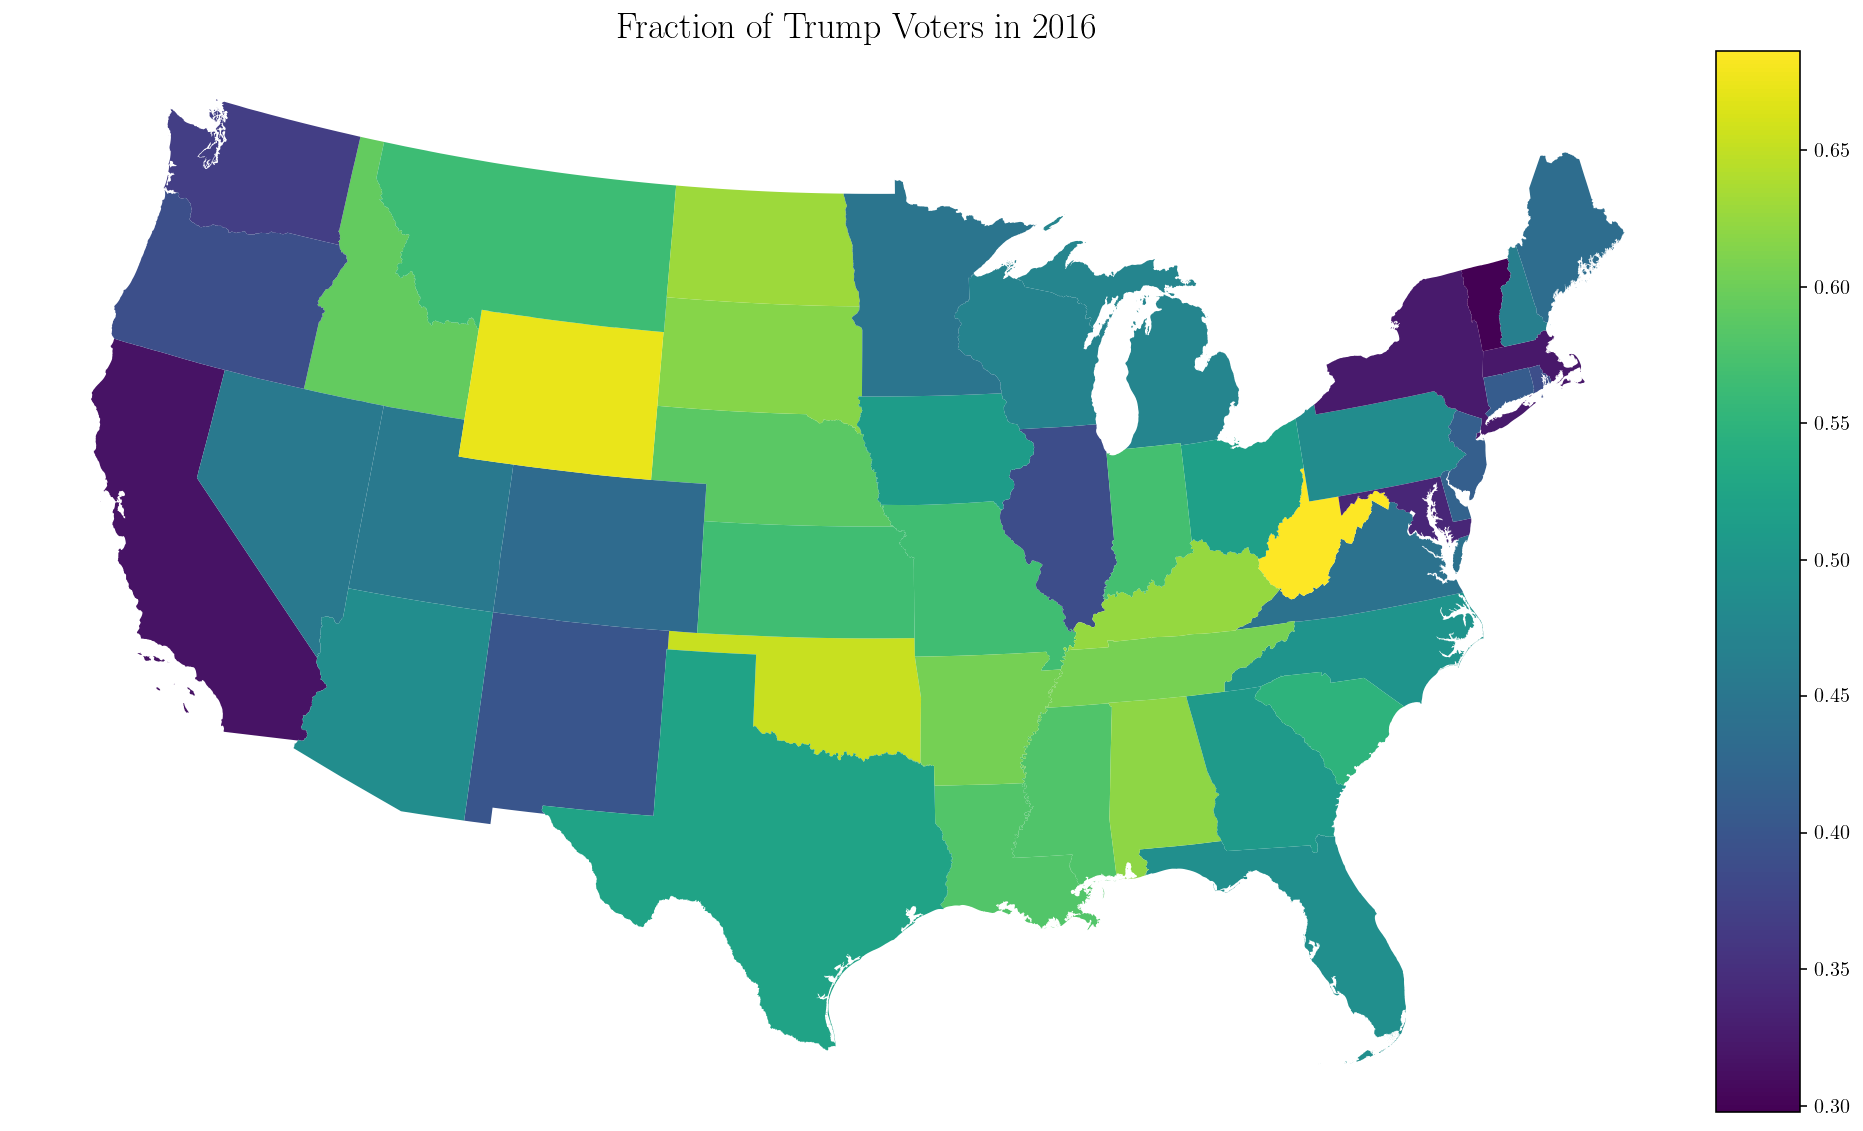

In [19]:
tmp = minimal.loc[~minimal['STUSPS'].isin(['DC'])] #So few republicans it makes the colorscale useless
fig = plt.figure(figsize=(16,10))
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
tmp.plot(ax=ax, column='rfrac', legend=True, cax=cax)
ax.set_title('Fraction of Trump Voters in 2016',fontsize=18)
ax.axis('off')
plt.show()

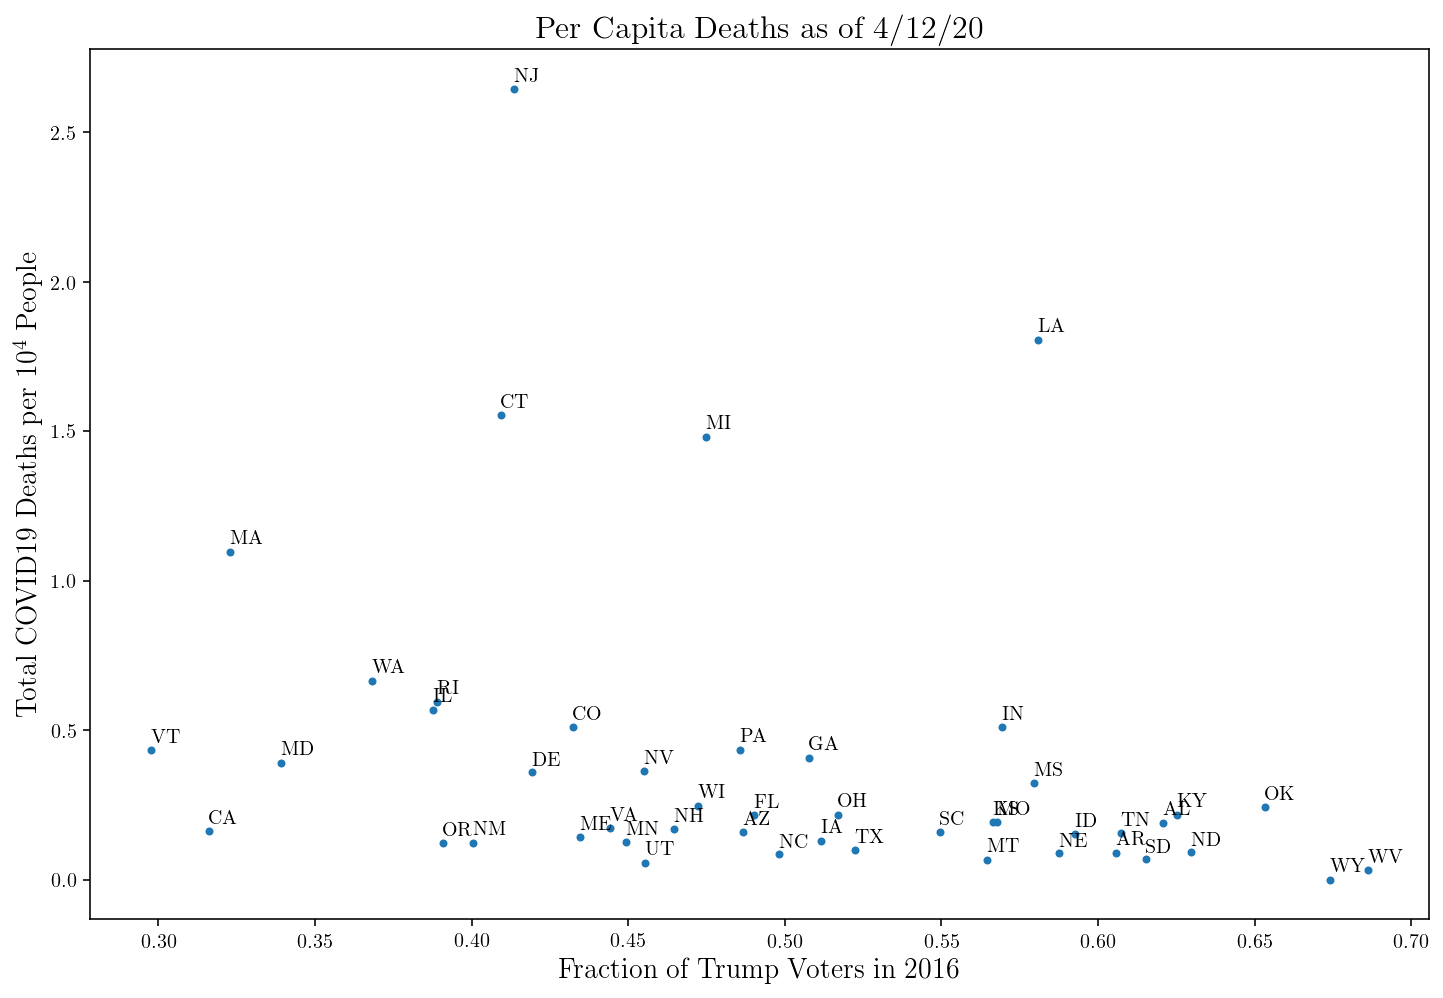

In [20]:
tmp = minimal.loc[~minimal['STUSPS'].isin(['NY','DC'])]
tmp = tmp.reset_index()
plt.figure(figsize=(12,8))
plt.scatter(tmp['rfrac'], tmp['td_per10k_now'], marker='.')
ax = plt.gca()
for i,t in enumerate(tmp['STUSPS']):
    ax.annotate(t, (tmp['rfrac'][i], tmp['td_per10k_now'][i]+0.025), fontsize=10)
ax.set_ylabel(r'Total COVID19 Deaths per $10^4$ People',fontsize=14)
ax.set_xlabel(r'Fraction of Trump Voters in 2016',fontsize=14)
plt.title("Per Capita Deaths as of 4/12/20",fontsize=16)
#plt.savefig('covid_vs_rfrac.png',dpi=500)
plt.show()

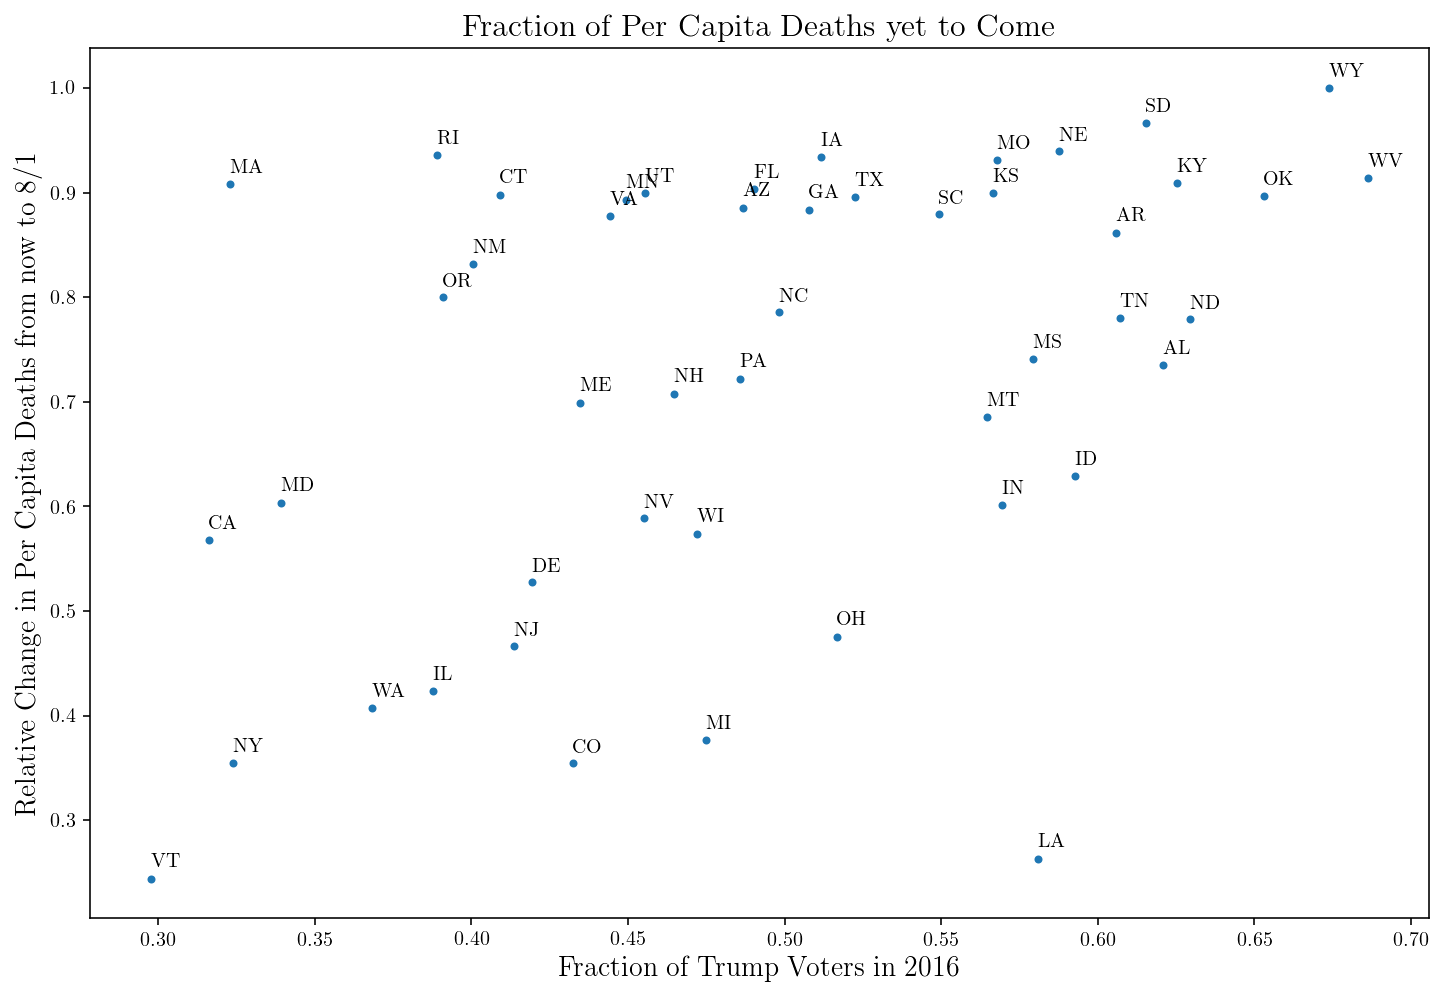

In [21]:
tmp = minimal.loc[~minimal['STUSPS'].isin(['DC'])]
tmp = tmp.reset_index()
plt.figure(figsize=(12,8))
plt.scatter(tmp['rfrac'], tmp['td_tocome'], marker='.')
ax = plt.gca()
for i,t in enumerate(tmp['STUSPS']):
    ax.annotate(t, (tmp['rfrac'][i], tmp['td_tocome'][i]+0.01), fontsize=10)
ax.set_xlabel(r'Fraction of Trump Voters in 2016',fontsize=14)
ax.set_ylabel(r'Relative Change in Per Capita Deaths from now to 8/1',fontsize=14)
plt.title("Fraction of Per Capita Deaths yet to Come",fontsize=16)
#plt.savefig('delta_pcd_vs_rfrac.png',dpi=500)
plt.show()